In [6]:
import typing
import itertools

import numpy
import pandas 

import scipy
import statsmodels
import statsmodels.stats
import statsmodels.stats.descriptivestats

import seaborn

import llm_questionnaires as llmq

In [7]:
MODELS: typing.List[str] = llmq.CONSTANTS.MODELS[:-1]
MODELS

['llama3.1-8b',
 'llama3.3-70b',
 'mistral-7b',
 'mistral-large-123b',
 'qwen2.5-7b']

In [8]:
COLUMNS: typing.List[str] = [col[0] + str(col[1]) for col in itertools.product("ENCAO" , range(1, 11))]

In [9]:
raw: typing.Dict[str, pandas.DataFrame]= {
    **llmq.evaluation.read_populations("data/base", MODELS, COLUMNS),
    "human_full": (
        pandas.read_csv("../../../data/big_5/survey.csv")
        .rename_axis(index="participant")
        .filter(regex='E|N|C|A|O', axis=1)
        .replace(-1, None)
        .apply(pandas.to_numeric)
    ),
    "random": (
        pandas.DataFrame(numpy.random.randint(0,5, (1000, 50)), columns=COLUMNS)
        .rename_axis(index="participant")
    )
}

raw.keys()

dict_keys(['llama3.1-8b', 'llama3.3-70b', 'mistral-7b', 'mistral-large-123b', 'qwen2.5-7b', 'human_full', 'random'])

In [10]:
for key, values in raw.items():
    values.to_csv(f"reports/raw.{key}.csv", index=False)

In [11]:
descriptive = pandas.concat({
    key: statsmodels.stats.descriptivestats.describe(values).T
    for key, values in raw.items()
})
descriptive

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)


nobs  missing      mean   std_err  upper_ci  lower_ci  \
llama3.1-8b E1   1000.0     12.0  3.374494  0.034954  3.443003  3.305985   
            E2   1000.0      7.0  3.087613  0.024461  3.135555  3.039671   
            E3   1000.0      7.0  3.139980  0.014017  3.167453  3.112507   
            E4   1000.0     10.0  2.808081  0.034354  2.875413  2.740748   
            E5   1000.0     22.0  3.246421  0.039669  3.324171  3.168671   
...                 ...      ...       ...       ...       ...       ...   
random      O6   1000.0      0.0  1.995000  0.044822  2.082849  1.907151   
            O7   1000.0      0.0  2.041000  0.044870  2.128944  1.953056   
            O8   1000.0      0.0  2.064000  0.043930  2.150101  1.977899   
            O9   1000.0      0.0  1.970000  0.044554  2.057325  1.882675   
            O10  1000.0      0.0  1.970000  0.043761  2.055770  1.884230   

                      std  iqr  iqr_normal       mad  ...  median   1%   5%  \
llama3.1-8b E1   1.098695  2.0    1.482602  0.964104  ...     4.0  1.0  2.0   
            E2   0.770799  0.0    0.000000  0.502016  ...     3.0  1.0  2.0   
            E3   0.441705  0.0    0.000000  0.255553  ...     3.0  3.0  3.0   
            E4   1.080920  1.0    0.741301  0.849791  ...     3.0  1.0  1.0   
            E5   1.240568  1.0    0.741301  0.986691  ...     3.0  1.0  1.0   
...                   ...  ...         ...       ...  ...     ...  ...  ...   
random      O6   1.417386  2.0    1.482602  1.201960  ...     2.0  0.0  0.0   
            O7   1.418919  2.0    1.482602  1.212708  ...     2.0  0.0  0.0   
            O8   1.389185  2.0    1.482602  1.177776  ...     2.0  0.0  0.0   
            O9   1.408930  2.0    1.482602  1.197280  ...     2.0  0.0  0.0   
            O10  1.383841  2.0    1.482602  1.162420  ...     2.0  0.0  0.0   

                 10%  25%  50%  75%  90%  95%  99%  
llama3.1-8b E1   2.0  2.0  4.0  4.0  5.0  5.0  5.0  
            E2   2.0  3.0  3.0  3.0  4.0  5.0  5.0  
            E3   3.0  3.0  3.0  3.0  4.0  4.0  5.0  
            E4   1.0  2.0  3.0  3.0  4.0  5.0  5.0  
            E5   1.0  3.0  3.0  4.0  5.0  5.0  5.0  
...              ...  ...  ...  ...  ...  ...  ...  
random      O6   0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O7   0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O8   0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O9   0.0  1.0  2.0  3.0  4.0  4.0  4.0  
            O10  0.0  1.0  2.0  3.0  4.0  4.0  4.0  

[350 rows x 31 columns]

In [12]:
raw["human_sampled"] = (
    pandas.DataFrame(numpy.stack([
        numpy.random.normal(row["mean"], row["std"], 1000).astype(int)
        for _, row in descriptive.loc["human_full"][["mean", "std"]].iterrows()
    ], axis=1), columns=COLUMNS)
    .rename_axis(index="participant")
)

In [13]:
pandas.concat({
    (key_1, key_2): (
        pandas.Series(
            scipy
            .stats.f_oneway(
                values_1,
                values_2,
                nan_policy="omit"
            )
            .pvalue
            > 0.05,
            name="f_oneway_significant"
        )
        .value_counts()
    )
    for key_1, values_1 in raw.items()
    for key_2, values_2 in raw.items()
}).to_frame()

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:618: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


count
                            f_oneway_significant       
llama3.1-8b   llama3.1-8b   True                     35
                            False                    15
              llama3.3-70b  False                    49
                            True                      1
              mistral-7b    False                    41
...                                                 ...
human_sampled qwen2.5-7b    True                      3
              human_full    False                    50
              random        False                    49
                            True                      1
              human_sampled True                     50

[116 rows x 1 columns]

In [14]:
sim = (
    llmq.evaluation.apply_calc_similarity(raw)
    .to_frame()
    .reset_index(level=[0, 1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    .reindex(
        columns=(idx := ["random", "human_sampled", "human_full", *MODELS]),
        index=idx
    )
    .pipe(llmq.evaluation.extract_triu_df)
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))

\begin{tabular}{lrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{random} & \rotatebox{65}{human\_sampled} & \rotatebox{65}{human\_full} & \rotatebox{65}{llama3.1-8b} & \rotatebox{65}{llama3.3-70b} & \rotatebox{65}{mistral-7b} & \rotatebox{65}{mistral-large-123b} & \rotatebox{65}{qwen2.5-7b} \\
level_0 &  &  &  &  &  &  &  &  \\
\midrule
random &  &  &  &  &  &  &  &  \\
human\_sampled & 0.014 &  &  &  &  &  &  &  \\
human\_full & 0.022 & 0.002 &  &  &  &  &  &  \\
llama3.1-8b & 0.027 & -0.017 & -0.007 &  &  &  &  &  \\
llama3.3-70b & 0.009 & 0.012 & 0.009 & -0.040 &  &  &  &  \\
mistral-7b & 0.022 & 0.026 & 0.010 & 0.007 & 0.014 &  &  &  \\
mistral-large-123b & 0.010 & -0.030 & 0.012 & -0.050 & -0.003 & -0.032 &  &  \\
qwen2.5-7b & 0.033 & 0.012 & -0.039 & -0.044 & 0.016 & 0.085 & -0.030 &  \\
\bottomrule
\end{tabular}



<Axes: xlabel='level_1', ylabel='level_0'>

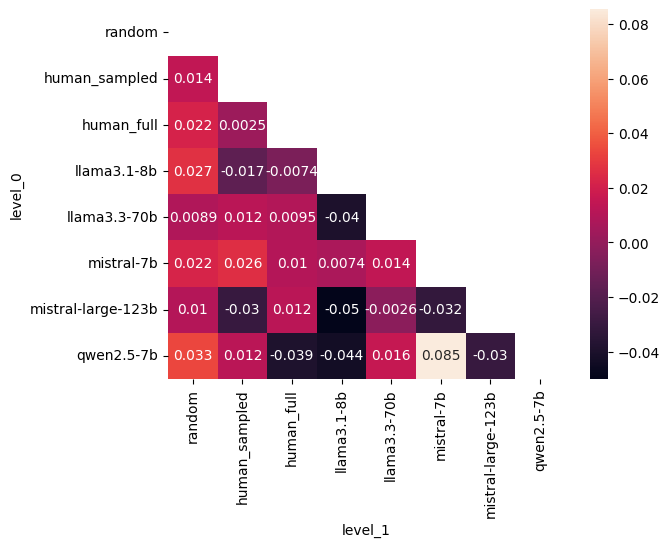

In [15]:
seaborn.heatmap(sim, annot=True, mask=numpy.triu(sim))

In [17]:
human_chunked = {
    f"{n:02d}": chunk
    for n, chunk in enumerate(numpy.array_split(raw["human_full"].sample(frac=1.0), 20), start=1)
}

sim = (
    llmq.evaluation.apply_calc_similarity(human_chunked)
    .to_frame()
    .reset_index(level=[0,1])
    .pivot_table(values="similarity", index="level_0", columns="level_1")
    #
    .where(lambda df: pandas.DataFrame(
        [[i > j for j in range(len(df.columns))] for i in range(len(df.index))],
        index=df.index,
        columns=df.columns
    ))
    
)
sim

print(sim.pipe(llmq.evaluation.format_latex_df))
print({
    "mean": sim.stack().mean(),
    "std": sim.stack().std()
})

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
level_1 & \rotatebox{65}{01} & \rotatebox{65}{02} & \rotatebox{65}{03} & \rotatebox{65}{04} & \rotatebox{65}{05} & \rotatebox{65}{06} & \rotatebox{65}{07} & \rotatebox{65}{08} & \rotatebox{65}{09} & \rotatebox{65}{10} & \rotatebox{65}{11} & \rotatebox{65}{12} & \rotatebox{65}{13} & \rotatebox{65}{14} & \rotatebox{65}{15} & \rotatebox{65}{16} & \rotatebox{65}{17} & \rotatebox{65}{18} & \rotatebox{65}{19} & \rotatebox{65}{20} \\
level_0 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
01 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
02 & 0.974 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
03 & 0.969 & 0.963 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
04 & 0.976 & 0.974 & 0.964 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
05 & 0.973 & 0.970 & 0.964 & 0.973 &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
06 & 0.974 & 0.971 & 0.963 & 0.974 & 0.971 &  &  &  &  &  &  

<Axes: xlabel='level_1', ylabel='level_0'>

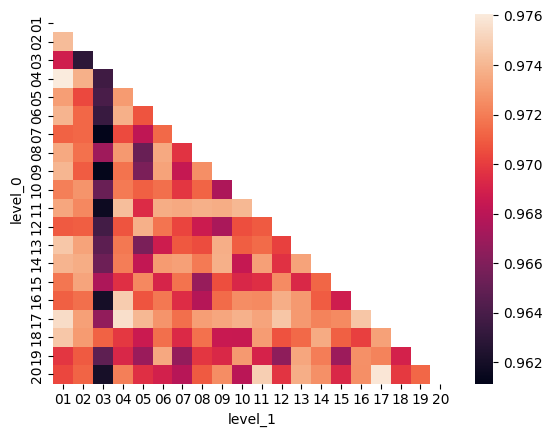

In [20]:
seaborn.heatmap(sim, annot=False, mask=numpy.triu(sim))